In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import itertools
from torchvision.datasets import DatasetFolder

In [7]:
import torch
print(torch.cuda.is_available())  # Should return True if the GPU is available
print(torch.__version__)          # Check the installed PyTorch version
print(torch.version.cuda) 

False
2.4.1+cpu
None


In [9]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [11]:
# Define transformations with added data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(224, padding=8, padding_mode='reflect'),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [15]:
# Load the dataset
#data_dir = 'D:/CowData/Output'  # Replace with the path to your data directory
#dataset = ImageFolder(root=data_dir, transform=transform)

"""# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])"""

""""# Create data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)"""
# Load the training dataset
train_data_dir = r"C:\\Users\\User2\\Desktop\\Valid_cow_project_phase2\\splitted_cow_clusters\\train" #location for training data
train_dataset = ImageFolder(root=train_data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Load the validation dataset

val_data_dir = r"C:\\Users\\User2\\Desktop\\Valid_cow_project_phase2\\splitted_cow_clusters\\val"  #location for val data
val_dataset = ImageFolder(root=val_data_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the test dataset
test_data_dir = r"C:\\Users\\User2\\Desktop\\Valid_cow_project_phase2\\splitted_cow_clusters\\test"  #locaion for test data
test_dataset = ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

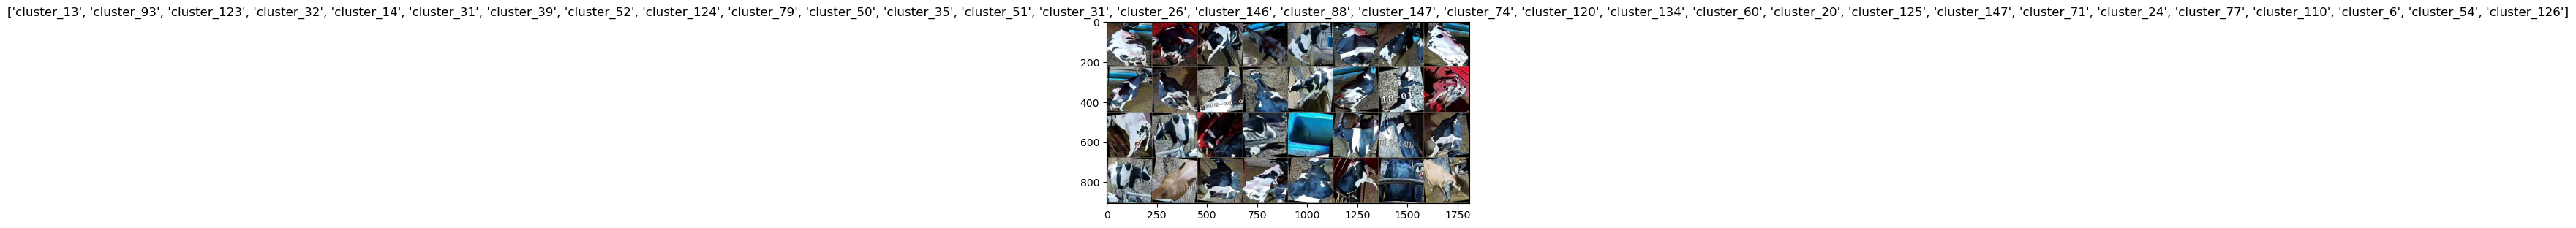

In [17]:
# Function to denormalize and display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = vutils.make_grid(inputs)

imshow(out, title=[train_dataset.classes[x] for x in classes])

In [19]:
class SENetBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(SENetBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio)
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        s = self.avg_pool(x).view(b, c)
        s = F.relu(self.fc1(s))
        s = torch.sigmoid(self.fc2(s)).view(b, c, 1, 1)
        return x * s.expand_as(x)

In [21]:
class CowIdentificationModel(nn.Module):
    def __init__(self, num_classes=174):#initialized with 46 classes
        super(CowIdentificationModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.5)  # Added dropout
        )

        self.se_block = SENetBlock(256)# a Squeeze-and-Excitation (SE) block, which enhances the representation of features within the network.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))#reduces the spatial dimensions of the feature map to 1x1, retaining the depth.
        self.classifier = nn.Linear(256, num_classes)#produces the final classification scores
   # def forward(self, x):#specifies how the input data  is processed by the model to produce an output
    #    x = self.features(x)#feature extraction
     #   x = self.se_block(x)
      #  x = self.global_avg_pool(x)
       # x = x.view(x.size(0), -1)
        #x = self.classifier(x)
        #return x


# Compute feature vectors of images using the CowIdentificationModel.

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = self.se_block(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        if return_features:
            return x
        x = self.classifier(x)
        return x

In [23]:
# Instantiate the model
"""model = CowIdentificationModel()
print(model)"""
# Instantiate the model and move to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CowIdentificationModel().to(device)

In [25]:
# Define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)  # Increased learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adjust weight_decay for L2 regularization

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler

def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)
model.apply(initialize_weights)

CowIdentificationModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
 

In [27]:
# Function to evaluate the model on a given dataset
def evaluate(model, loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [29]:
import torch

for inputs, labels in train_loader:
    if not ((labels >= 0) & (labels < 150)).all():
        print(f"Invalid labels detected: {labels}")
    inputs, labels = inputs.to(device), labels.to(device)
    ...


In [33]:
# Function to train the model
# def train_model(model, train_loader, val_loader, num_epochs):
#     best_val_accuracy = 0
#     for epoch in range(num_epochs):
#         model.train()
#         for inputs, labels in train_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#         val_accuracy = evaluate(model, val_loader, device)
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             # Save the best model
#             torch.save(model.state_dict(), 'best_model.pt')

#         print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%')

#         scheduler.step()

#     print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')

def train_model(model, train_loader, val_loader, num_epochs):
    best_val_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        val_accuracy = evaluate(model, val_loader, device)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            # Save the best model as .pt
            torch.save(model, 'best_model.pt')  # Save the entire model (architecture + state_dict)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy:.2f}%')

        scheduler.step()

    print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')


In [35]:
# Train and evaluate the model
num_epochs = 15  # Define the number of epochs you wish to train for
train_model(model, train_loader, val_loader, num_epochs)

Epoch 1/15, Validation Accuracy: 27.06%
Epoch 2/15, Validation Accuracy: 52.92%
Epoch 3/15, Validation Accuracy: 64.77%
Epoch 4/15, Validation Accuracy: 65.04%
Epoch 5/15, Validation Accuracy: 65.85%
Epoch 6/15, Validation Accuracy: 69.86%
Epoch 7/15, Validation Accuracy: 72.24%
Epoch 8/15, Validation Accuracy: 81.82%
Epoch 9/15, Validation Accuracy: 81.76%
Epoch 10/15, Validation Accuracy: 82.41%
Epoch 11/15, Validation Accuracy: 83.55%
Epoch 12/15, Validation Accuracy: 82.52%
Epoch 13/15, Validation Accuracy: 83.17%
Epoch 14/15, Validation Accuracy: 83.44%
Epoch 15/15, Validation Accuracy: 83.60%
Best Validation Accuracy: 83.60%


In [39]:
# Load the best model
# model.load_state_dict(torch.load('best_model.pt'))
# Load the entire model
model = torch.load('best_model.pt')
model.to(device)  # Ensure the model is on the correct device


C:\Users\User2\AppData\Local\Temp\ipykernel_24928\2958736760.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pt')


CowIdentificationModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
 

In [41]:
# Evaluate on the test set
test_accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 82.56%


In [43]:
# Function to calculate and display accuracies per cluster
def accuracies_per_cluster(loader, model, device):
    cluster_accuracies = {}
    total_correct = 0
    total_images = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()

            for label, prediction in zip(labels, predicted):
                cluster = train_loader.dataset.classes[label.item()]
                if cluster not in cluster_accuracies:
                    cluster_accuracies[cluster] = {'correct': 0, 'total': 0}
                cluster_accuracies[cluster]['total'] += 1
                cluster_accuracies[cluster]['correct'] += (prediction == label).item()

    for cluster, stats in cluster_accuracies.items():
        accuracy = 100 * stats['correct'] / stats['total']
        cluster_accuracies[cluster] = accuracy

    overall_accuracy = 100 * total_correct / total_images
    #print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    return cluster_accuracies
#Calculate and print accuracy per cluster for validation and test sets
print("Validation Set Accuracies Per Cluster:")
val_cluster_accuracies = accuracies_per_cluster(val_loader, model, device)
print(val_cluster_accuracies)

print("\nTest Set Accuracies Per Cluster:")
test_cluster_accuracies = accuracies_per_cluster(test_loader, model, device)
print(test_cluster_accuracies)

Validation Set Accuracies Per Cluster:
{'cluster_0': 87.5, 'cluster_1': 100.0, 'cluster_10': 73.6842105263158, 'cluster_100': 68.75, 'cluster_101': 100.0, 'cluster_102': 100.0, 'cluster_103': 80.0, 'cluster_104': 94.44444444444444, 'cluster_105': 100.0, 'cluster_106': 82.14285714285714, 'cluster_107': 100.0, 'cluster_108': 94.11764705882354, 'cluster_109': 72.72727272727273, 'cluster_11': 66.66666666666667, 'cluster_110': 64.70588235294117, 'cluster_111': 84.61538461538461, 'cluster_112': 100.0, 'cluster_113': 83.33333333333333, 'cluster_114': 100.0, 'cluster_115': 100.0, 'cluster_116': 40.0, 'cluster_117': 82.3529411764706, 'cluster_118': 80.0, 'cluster_119': 91.66666666666667, 'cluster_12': 75.0, 'cluster_120': 100.0, 'cluster_121': 0.0, 'cluster_122': 81.81818181818181, 'cluster_123': 62.5, 'cluster_124': 85.71428571428571, 'cluster_125': 90.9090909090909, 'cluster_126': 100.0, 'cluster_127': 100.0, 'cluster_128': 90.47619047619048, 'cluster_129': 88.88888888888889, 'cluster_13': 10

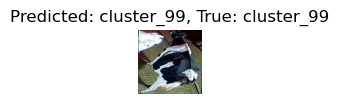

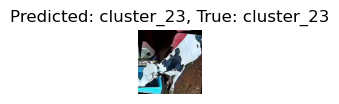

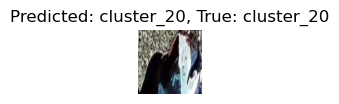

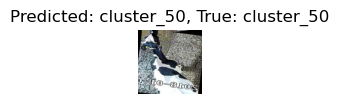

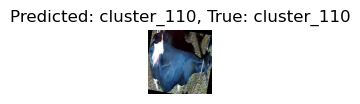

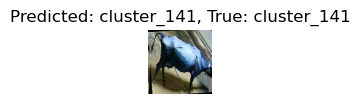

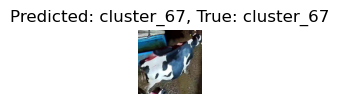

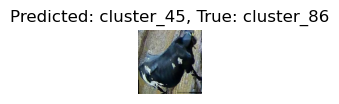

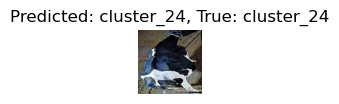

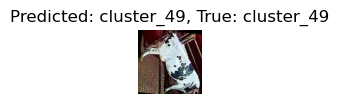

In [44]:
# Function to display accuracies in a table format
def visualize_train_predictions(model, train_loader, num_images=10):#to check if the model learns properly
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # Calculate the number of rows for subplots
    num_rows = (num_images + 1) // 2

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_rows, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {train_dataset.classes[preds[j]]}, True: {train_dataset.classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

visualize_train_predictions(model, train_loader)

In [47]:
# Define transformations for the test images
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by the model
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

In [49]:
# Function to Compute Cluster Centroids
def compute_cluster_centroids(dataset, model, device):
    clusters = {label: [] for label in dataset.classes}
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            features = model(inputs, return_features=True)
            for feature, label in zip(features, labels):
                clusters[dataset.classes[label.item()]].append(feature.cpu().numpy())

    centroids = {label: np.mean(np.vstack(features), axis=0) for label, features in clusters.items()}
    return centroids

# Compute centroids
centroids = compute_cluster_centroids(train_dataset, model, device)

In [50]:
def predict_image(image_path, model, transform, centroids, threshold=0.9):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        features = model(image_tensor, return_features=True)

        # Calculate similarities with all cluster centroids
        similarities = {}
        for label, centroid in centroids.items():
            cluster_features = torch.tensor(centroid).to(device)
            similarity = F.cosine_similarity(features, cluster_features.unsqueeze(0)).item()
            similarities[label] = similarity

        # Determine the most similar cluster
        most_similar_cluster = max(similarities, key=similarities.get)
        max_similarity = similarities[most_similar_cluster]

        # Check against the threshold
        if max_similarity < threshold:
            print("This cow seems to be new.")
            return "new", max_similarity
        else:
            print(f"Predicted: {most_similar_cluster} with similarity: {max_similarity}")

            return most_similar_cluster, max_similarity


# image_path = r'/content/drive/My Drive/split_folders/prediction/cow10.png'
image_path = r"C:\\Users\\User2\\Desktop\\cowdata\\IMG_6761.jpg"
predicted_label, similarity = predict_image(image_path, model, test_transform, centroids)


This cow seems to be new.


In [51]:
def calculate_metrics_manual(preds, labels):
    # Convert to tensor if they are not
    if not isinstance(preds, torch.Tensor): preds = torch.tensor(preds)
    if not isinstance(labels, torch.Tensor): labels = torch.tensor(labels)

    # Calculate True Positives, False Positives, False Negatives
    TP = (preds * labels).sum().to(torch.float32)
    TN = ((1 - preds) * (1 - labels)).sum().to(torch.float32)
    FP = (preds * (1 - labels)).sum().to(torch.float32)
    FN = ((1 - preds) * labels).sum().to(torch.float32)

    # Calculate Precision, Recall, F1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    # In case of no true positives, the scores should be zero
    if torch.isnan(precision): precision = torch.tensor(0.)
    if torch.isnan(recall): recall = torch.tensor(0.)
    if torch.isnan(f1): f1 = torch.tensor(0.)

    return precision.item(), recall.item(), f1.item()

In [55]:
# Function to evaluate the model and return predictions and labels
def get_all_preds_labels(model, loader, device):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [57]:
# Now, use these functions to calculate and print precision, recall, F1 for validation and test sets

preds, labels = get_all_preds_labels(model, val_loader, device)
val_precision, val_recall, val_f1 = calculate_metrics_manual(preds, labels)
print(f"Validation - Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}")

preds, labels = get_all_preds_labels(model, val_loader, device)
val_precision, val_recall, val_f1 = calculate_metrics_manual(preds, labels)
print(f"Validation - Precision: {val_precision}, Recall: {val_recall}, F1: {val_f1}")

preds, labels = get_all_preds_labels(model, test_loader, device)
test_precision, test_recall, test_f1 = calculate_metrics_manual(preds, labels)
print(f"Test - Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}")

Validation - Precision: 94.00890350341797, Recall: 93.85611724853516, F1: 93.93244934082031
Validation - Precision: 93.73745727539062, Recall: 93.63819122314453, F1: 93.68780517578125
Test - Precision: 93.47089385986328, Recall: 93.04756927490234, F1: 93.25875091552734
